**A/B Testing trong Marketing**

Một công ty đang muốn xác định hiệu quả của các chiến dịch quảng cáo đã tiến hành A/B Testing, một phương pháp phổ biến trong nghiên cứu thị trường.
- Nhóm thử nghiệm (AD): Phần lớn người dùng được tiếp xúc với quảng cáo.
- Nhóm đối chứng (PSA): Một nhóm nhỏ hơn chỉ thấy Quảng Cáo Dịch Vụ Công Cộng hoặc không thấy nội dung gì ở vị trí quảng cáo.

**Mục tiêu phân tích:**
- Xác định xem quảng cáo có thực sự hiệu quả không bằng cách đo lường và so sánh Tỷ lệ chuyển đổi (conversion rate) giữa hai nhóm.
- Xem xét sự khác biệt thống kê giữa hai nhóm, để đảm bảo rằng bất kỳ khác biệt nào được phát hiện không phải là ngẫu nhiên.


---



**Cấu trúc bài phân tích:**
- Kiểm định giả thuyết về mối liên hệ giữa việc chạy quảng cáo và tỷ lệ chuyển đổi:
  - **Chi-square test for independence**
  - **Welch's t-test**
- Kiểm định giả thuyết về sự khác biệt giữa tỷ lệ chuyển đổI giữa nhóm thử nghiệm (experimental group) và nhóm đối chứng (control group)
  - **Hypothesis Testing With Two Proportions**



In [1]:
#  import thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# kết nối GGDrive
from  google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load data
df_ab = pd.read_csv('/content/drive/MyDrive/PYTHON/Project/AB_Test/marketing_AB_.csv')

# **1. Clean Dataset**

In [4]:
df_ab.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [5]:
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [6]:
df_ab.isnull().sum()

,0
Unnamed: 0,0
user id,0
test group,0
converted,0
total ads,0
most ads day,0
most ads hour,0


In [7]:
df_ab['user id'].nunique()

588101

# **2. Power Analysis**
**Mục đích:** tính toán cỡ mẫu tối thiểu cần thiết nhằm đảm bảo khả năng phát hiện hiệu ứng (effect size) với độ tin cậy nhất định, với mức ý nghĩa 𝛼 = 0.05

Power Analysis thường được tiến hành trước khi chạy A/B Testing. Nhằm đảm bảo đủ số lượng người tham gia trong mỗi nhóm thử nghiệm và đối chứng, đồng thời hạn chế việc lãng phí tài nguyên.

=> Số lượng mẫu đủ sẽ giúp tăng xác suất phát hiện sự khác biệt thực sự nếu tồn tại.


---


Trong trường hợp này, công ty đã chạy xong quảng cáo, Power Analysis sẽ được dùng để đánh giá liệu cỡ mẫu hiện tại có đủ lớn để phân tích kết quả chính xác hay không.

In [8]:
# Kiểm tra cỡ mẫu hiện tại
df_ab.groupby('test group')['user id'].count()

,user id
test group,
ad,564577
psa,23524


## 2.1. Effect Size (Cohen’s d Formula)
Effect size = $ \frac{p2 - p1}{S_{pool}} $.

Trong đó:
- p1 = tỷ lệ chuyển đổi của nhóm ad (exprimental group)
- p2 = tỷ lệ chuyển đổi của nhóm psa (control group)
- $ S_{pool} $ = Độ lệch chuẩn gộp (pooled standard deviation), tính bằng công thức
  - $ S_{pool} = \sqrt{\frac{(n_1 - 1)s_1^2 + (n_2 - 1)s_2^2}{n_1 + n_2 - 2}} $
    - n1 = số lượng sample nhóm ad
    - n2 = số lượng sample nhóm psa
    - s1 = độ lệch chuẩn nhóm ad
    - s2 = độ lệch chuẩn nhóm psa

In [9]:
group_ad = df_ab[df_ab['test group'] == 'ad']
group_psa = df_ab[df_ab['test group'] == 'psa']

cross_tab = pd.crosstab(df_ab['test group'], df_ab['converted'], normalize='index')

p1 = cross_tab.loc['ad', True]      # Tỉ lệ chuyển đổi nhóm ad
p2 = cross_tab.loc['psa', True]     # Tỉ lệ chuyển đổi nhóm psa
n1 = group_ad['user id'].nunique()  # Số lượng user trong nhóm ad
n2 = group_psa['user id'].nunique() # Số lượng user trong nhóm psa
s1 = group_ad['converted'].std()    # Độ lệch chuẩn sample nhóm ad
s2 = group_psa['converted'].std()   # Độ lệch chuẩn sample nhóm psa

In [10]:
# tính Độ lệch chuẩn gộp (pooled standard deviation)
Sp = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))

# tính Effect Size
effect_size = abs(p1 - p2) / Sp

effect_size

0.04904561593068279

**NOTES:**
- Effect size = 0.049 nhỏ hơn rất nhiều so với ngưỡng "Small" (0.2) theo tiêu chuẩn Cohen's d.
- Điều này cho thấy sự khác biệt giữa experimental group (nhóm thử nghiệm) và test group (nhóm đối chứng) là rất nhỏ và khó có thể cảm nhận được.

## 2.2. Mẫu tối thiểu với mỗi Sample (Required sample size)

In [11]:
import statsmodels.stats.api as sms

alpha = 0.05       # level of significant
power = 0.8        # Test Power (1- beta)

# Khởi tạo đối tượng power analysis cho t-test hai mẫu
PowerAnalysis = sms.NormalIndPower()

# Tính số lượng mẫu cần thiết cho mỗi nhóm
nobs1 = PowerAnalysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1.0, alternative='two-sided')

size = int(np.ceil(nobs1))

print(f"Cỡ mẫu tối thiểu cho bài phân tích là: {size}")

Cỡ mẫu tối thiểu cho bài phân tích là: 6526


**NOTES:**
- Sample size cần thiết tối thiểu là 6526
- Bình thường, **bước tính Power Analysis là trước khi nghiên cứu bắt đầu**. Do ở đây đã thu thập số liệu rồi nên để tránh lãng phí tài nguyên (do công ty đã thu thập được 23,524 mẫu với nhóm psa)

**=> Chọn cỡ mẫu là 23,000 cho cả 2 nhóm**

In [12]:
min_size = 23000

# Random mỗi nhóm 23000 dòng
df_ad_sample = df_ab[df_ab['test group'] == 'ad'].sample(n=min_size, random_state=42)
df_psa_sample = df_ab[df_ab['test group'] == 'psa'].sample(n=min_size, random_state=42)

# Kết hợp các dòng mẫu lại với nhau
df_ab_test = pd.concat([df_ad_sample, df_psa_sample]).reset_index()

df_ab_test = df_ab_test.drop(columns=['index', 'Unnamed: 0'], errors='ignore')

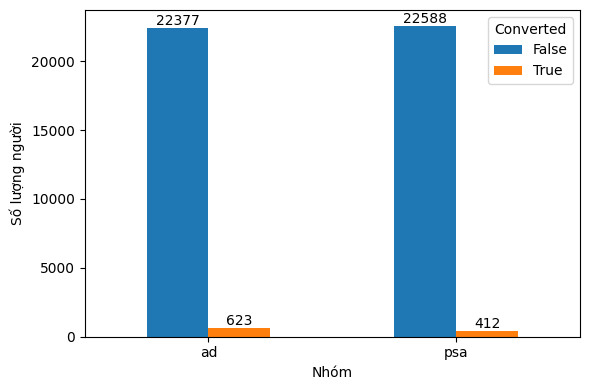

In [13]:
# VISUALIZE

# Tạo Dataframe tính theo 2 nhóm ad - psa
data = df_ab_test.groupby(['test group', 'converted'])['user id'].count().unstack()

# Tạo biểu đồ cột
ax = data.plot(kind='bar', figsize=(6, 4), color=['#1f77b4', '#ff7f0e'])

plt.xlabel('Nhóm')
plt.ylabel('Số lượng người')
plt.legend(title='Converted', labels=['False', 'True'])
plt.xticks(rotation=0)

# Add data labels
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

# Show plot
plt.tight_layout()
plt.show()

# **3. Chi-Square Test for Independence**
- **Mục đích:** Kiểm tra xem việc chạy ads (quảng cáo) có mối liên hệ với tỉ lệ chuyển đổi (conversion rate) không?
- Để kiểm tra, em sẽ xét độ tương quan giữa:
  - Cột "converted" và "most ads day"
  - Cột "converted" và "most ads hour"

## 3.1. Most ads day


**Mục đích:** Muốn kiểm tra xem ngày chạy nhiều quảng cáo nhất trong tuần có tác động đến tỷ lệ chuyển đổi không?
- $ H_{0} $: Cột "converted" và "most ads day" phụ thuộc nhau
- $ H_{A} $: Cột "converted" và "most ads day" không phụ thuộc nhau

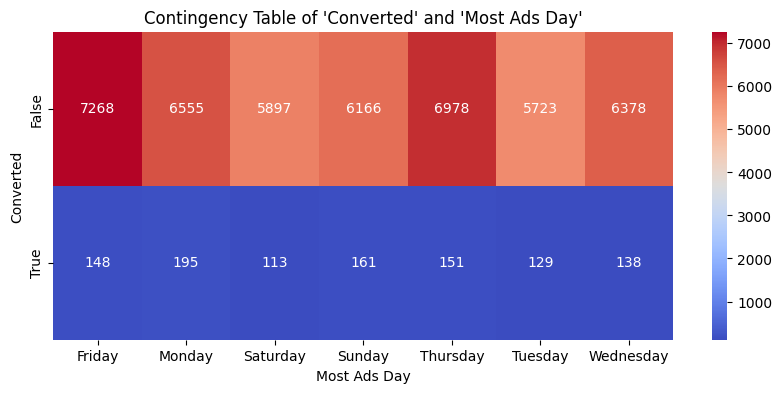


Chi-squared test statistic: 22.07895637710061
P-value: 0.0011716199872981233
Degrees of freedom: 6

=> Loại bỏ giả thiết H0. Có đủ bằng chứng để nhận định rằng có mối liên hệ giữa cột converted và most ads day


In [14]:
from scipy.stats import chi2_contingency

# contingency table
contingency_day = pd.crosstab(df_ab_test['converted'], df_ab_test['most ads day'])

plt.figure(figsize=(10, 4))
sns.heatmap(contingency_day, annot=True, fmt="d", cmap="coolwarm", cbar=True)
plt.title("Contingency Table of 'Converted' and 'Most Ads Day'")
plt.xlabel("Most Ads Day")
plt.ylabel("Converted")
plt.show()

# Chi-square test
chi_day, p_day, df_day, expected = chi2_contingency(contingency_day)

print(f"\nChi-squared test statistic: {chi_day}")
print(f"P-value: {p_day}")
print(f"Degrees of freedom: {df_day}")

# Kết luận
alpha = 0.05

if p_day < alpha:
        print("\n=> Loại bỏ giả thiết H0. Có đủ bằng chứng để nhận định rằng có mối liên hệ giữa cột converted và most ads day")
else:
        print("\n=> Không đủ bằng chứng để loại bỏ giả thiết H0.")

## 3.2. Most ads hour


**Mục đích:** Muốn kiểm tra xem giờ chạy nhiều quảng cáo nhất trong ngày có tác động đến tỷ lệ chuyển đổi không?
- $ H_{0} $: Cột "converted" và "most ads hour" phụ thuộc nhau
- $ H_{A} $: Cột "converted" và "most ads hour" không phụ thuộc nhau

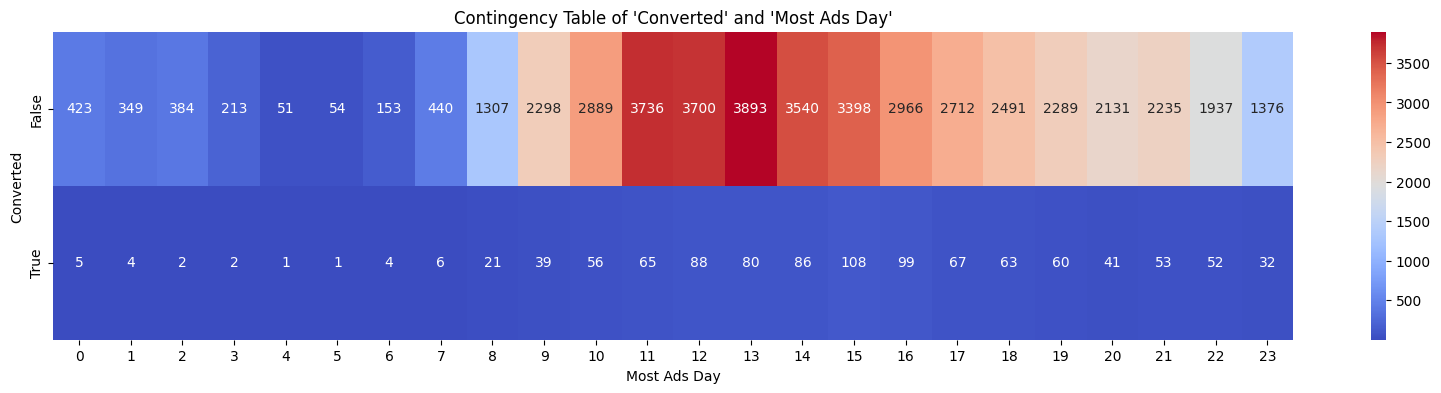


Chi-squared test statistic: 56.12570293427687
P-value: 0.00013592856482938108
Degrees of freedom: 23

=> Loại bỏ giả thiết H0. Có đủ bằng chứng để nhận định rằng có mối liên hệ giữa cột converted và most ads hour


In [15]:
# contingency table
contingency_hour = pd.crosstab(df_ab_test['converted'], df_ab_test['most ads hour'])

plt.figure(figsize=(20, 4))
sns.heatmap(contingency_hour, annot=True, fmt="d", cmap="coolwarm", cbar=True)
plt.title("Contingency Table of 'Converted' and 'Most Ads Day'")
plt.xlabel("Most Ads Day")
plt.ylabel("Converted")
plt.show()

# Chi-square test
chi_hour, p_hour, df_hour, expected = chi2_contingency(contingency_hour)

print(f"\nChi-squared test statistic: {chi_hour}")
print(f"P-value: {p_hour}")
print(f"Degrees of freedom: {df_hour}")

# Kết luận
alpha = 0.05

if p_hour < alpha:
        print("\n=> Loại bỏ giả thiết H0. Có đủ bằng chứng để nhận định rằng có mối liên hệ giữa cột converted và most ads hour")
else:
        print("\n=> Không đủ bằng chứng để loại bỏ giả thiết H0.")

## Kết luận:
**Most ads day**
- **Chi-Square test statistic** = 22.078
- **P-value** = 0.00117

=> P-value < 0.05 cho thấy rằng **có mối liên hệ về mặt thống kê** giữa ngày người dùng xem nhiều quảng cáo nhất (most ads day) và trạng thái chuyển đổi của họ (converted)


**Most ads hour**
- **Chi-Square test statistic** = 56.125
- **P-value** = 0.00013

=> P-value < 0.05 cho thấy rằng **có mối liên hệ về mặt thống kê** giữa giờ trong ngày người dùng xem nhiều quảng cáo nhất (most ads hour) và trạng thái chuyển đổi của họ (converted).


---


Ngày và giờ mà người dùng nhìn thấy nhiều quảng cáo nhất có ảnh hưởng đáng kể đến việc họ có chuyển đổi
- Tỉ lệ chuyển đổi cao nhất vào đầu tuần (Thứ Hai, Ba) - và giảm dần theo các ngày trong tuần và tăng lại vào Chủ nhật.
- Tỉ lệ chuyển đổi tăng dần từ buổi trưa đến chiều vào cao nhất vào 15h-16h

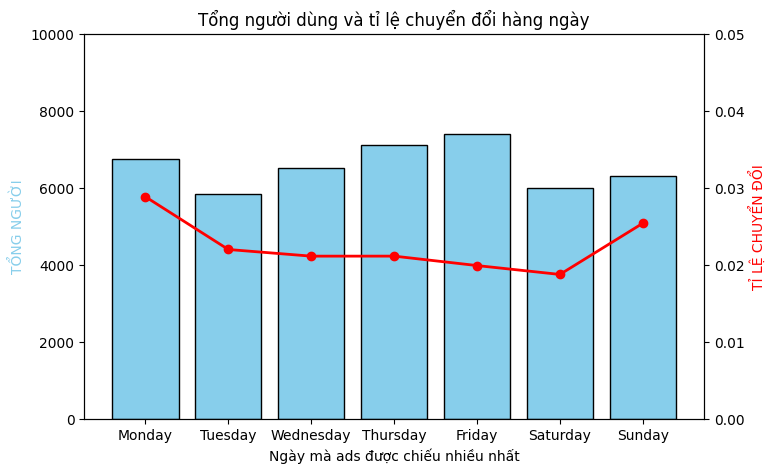

In [22]:
# Sắp xếp lại cột theo thứ tự: Thứ Hai -> Chủ nhật
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
contingency_day = contingency_day[days_order]

total_people_day = contingency_day.loc[True] + contingency_day.loc[False]   # Tổng số người mỗi ngày
conversion_rate_day = contingency_day.loc[True] / total_people_day # Tỉ lệ chuyển đổi

# Tạo biểu đồ
fig, ax1 = plt.subplots(figsize=(8, 5))

# Biểu đồ cột: Tổng số người
ax1.bar(contingency_day.columns, total_people_day, color='skyblue', edgecolor='black', label="Total People")

# Biểu đồ đường: Tỷ lệ chuyển đổi
ax2 = ax1.twinx()
ax2.plot(contingency_day.columns, conversion_rate_day, color='red', marker='o', label="Conversion Rate", linewidth=2)

# Đặt tiêu đề và nhãn trục
ax1.set_title("Tổng người dùng và tỉ lệ chuyển đổi hàng ngày")
ax1.set_xlabel("Ngày mà ads được chiếu nhiều nhất")
ax1.set_ylabel("TỔNG NGƯỜI", color='skyblue')
ax2.set_ylabel("TỈ LỆ CHUYỂN ĐỔI", color='red')

ax1.set_ylim(0, 10000)  # Giới hạn trục y cho tổng số người
ax2.set_ylim(0, 0.05)     # Giới hạn trục y cho tỷ lệ chuyển đổi

plt.xticks(rotation=0)
plt.show()

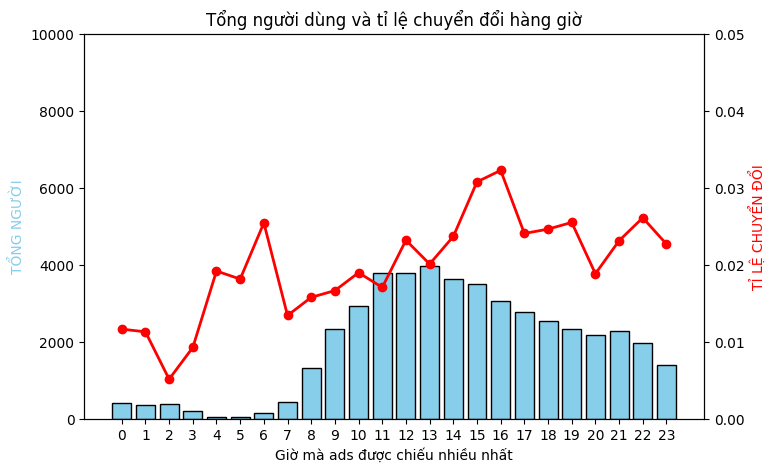

In [23]:
total_people_hour = contingency_hour.loc[True] + contingency_hour.loc[False]   # Tổng số người mỗi ngày
conversion_rate_hour = contingency_hour.loc[True] / total_people_hour # Tỉ lệ chuyển đổi

# Tạo biểu đồ
fig, ax1 = plt.subplots(figsize=(8, 5))

# Biểu đồ cột: Tổng số người
ax1.bar(contingency_hour.columns, total_people_hour, color='skyblue', edgecolor='black', label="Total People")

# Biểu đồ đường: Tỷ lệ chuyển đổi
ax2 = ax1.twinx()
ax2.plot(contingency_hour.columns, conversion_rate_hour, color='red', marker='o', label="Conversion Rate", linewidth=2)

# Đặt tiêu đề và nhãn trục
ax1.set_title("Tổng người dùng và tỉ lệ chuyển đổi hàng giờ")
ax1.set_xlabel("Giờ mà ads được chiếu nhiều nhất")
ax1.set_ylabel("TỔNG NGƯỜI", color='skyblue')
ax2.set_ylabel("TỈ LỆ CHUYỂN ĐỔI", color='red')

ax1.set_ylim(0, 10000)  # Giới hạn trục y cho tổng số người
ax2.set_ylim(0, 0.05)     # Giới hạn trục y cho tỷ lệ chuyển đổi

plt.xticks(range(0, 24), rotation=0)
plt.show()

# **4. T-Test: so sánh trung bình 2 tổng thể**
Để kiểm tra giả thuyết so sánh trung bình của hai tổng thể, có hai loại kiểm định t-test phổ biến:
- **Independent T-Test** (giả định rằng phương sai của hai tổng thể bằng nhau)
- **Welch’s T-Test** (giả định rằng phương sai của hai tổng thể khác nhau)

Để xác định phương sai của hai tổng thể có bằng nhau hay không, ta sử dụng Levene's Test.
- Nếu Levene's Test cho kết quả không có sự khác biệt phương sai (p-value > 0.05): Chọn Independent T-Test.
- Nếu Levene's Test cho thấy phương sai khác nhau (p-value ≤ 0.05): Chọn Welch's T-Test.

## Kiểm tra giả thuyết

### Phương sai tổng thể (Levene's test)

**Mục đích:** Muốn kiểm tra xem phương sai tổng thể có khác nhau hay không
- $ H_{0}: \sigma^2_{1} = \sigma^2_{2} $
- $ H_{A}: \sigma^2_{1} \neq \sigma^2_{2} $
  - $ \sigma^2_{1} $ = Phương sai converted (tổng thể)
  - $ \sigma^2_{2} $ = Phương sai not-converted (tổng thể)

In [18]:
from scipy.stats import levene

# tách dữ liệu
groupConverted = df_ab_test[df_ab_test['converted'] == True]['total ads']
groupNOTConverted = df_ab_test[df_ab_test['converted'] == False]['total ads']

# Levene's test
statistic, p_value = levene(groupConverted, groupNOTConverted)

print("Levene's test statistic:", statistic)
print("p-value:", p_value)

# Kết luận
alpha = 0.05
if p_value < alpha:
    print("Bác bỏ giả thuyết H0: Phương sai giữa các nhóm KHÔNG bằng nhau.")
    print("\n=> Kết luận: Chọn Welch's T-Test vì phương sai khác nhau (p-value ≤ 0.05).")
else:
    print("Không bác bỏ giả thuyết H0: Phương sai giữa các nhóm BẰNG nhau.")
    print("\n=> Kết luận: Chọn Independent T-Test vì không có sự khác biệt phương sai (p-value > 0.05).")

Levene's test statistic: 780.3031707448639
p-value: 2.750154486801534e-170
Bác bỏ giả thuyết H0: Phương sai giữa các nhóm KHÔNG bằng nhau.

=> Kết luận: Chọn Welch's T-Test vì phương sai khác nhau (p-value ≤ 0.05).


### Tính chuẩn (Normality)

In [33]:
n_Converted = groupConverted.count()  # Số mẫu trong nhóm converted
n_NOTConverted = groupNOTConverted.count()  # Số mẫu trong nhóm notconverted

# Kiểm tra kích thước mẫu
if n_Converted > 30 and n_NOTConverted > 30:
    print("Cả hai nhóm đều có kích thước mẫu > 30. Áp dụng Định lý giới hạn trung tâm, không cần kiểm tra phân phối chuẩn.")
else:
    # Kiểm tra Shapiro-Wilk nếu có nhóm nào có mẫu < 30
    if n_Converted < 30:
        stat_Converted, p_Converted = stats.shapiro(groupConverted)
        print(f"Shapiro-Wilk test for groupConverted: Statistics = {stat_Converted:.3f}, p-value = {p_Converted:.3f}")

    if n_NOTConverted < 30:
        stat_NOTConverted, p_NOTConverted = stats.shapiro(groupNOTConverted)
        print(f"Shapiro-Wilk test for groupNOTConverted: Statistics = {stat_NOTConverted:.3f}, p-value = {p_NOTConverted:.3f}")

Cả hai nhóm đều có kích thước mẫu > 30. Áp dụng Định lý giới hạn trung tâm, không cần kiểm tra phân phối chuẩn.


### Tính độc lập (Independence)
- Phân bổ vào hai nhóm là ngẫu nhiên
- Không có thành viên nào xuất hiện trong cả hai nhóm (nhóm converted và nhóm notconverted)

**=> 2 mẫu (sample) độc lập với nhau**

## **Welch’s T-Test**
**Giả thuyết:**
  * Mẫu độc lập với nhau
  * Phân phối mẫu là phân phối chuẩn.
  * Phương sai giữa 2 nhóm tổng thể là khác nhau

**Mục đích:** Kiểm tra xem chạy ads nhiều có đồng nghĩa là tỉ lệ chuyển đổi cao không => so sánh lượng ads chạy trung bình giữa 2 nhóm converted và not converted
- $ H_{0} : \mu_{converted} = \mu_{not-converted} $
- $ H_{A} : \mu_{converted} \neq \mu_{not-converted} $
  - $ \mu_{converted} $ = số lượng ads với nhóm converted
  - $ \mu_{not-converted} $ = số lượng ads với nhóm not-converted


In [19]:
from scipy.stats import ttest_ind

# groupConverted = df_ab_test[df_ab_test['converted'] == True]['total ads']
# groupNOTConverted = df_ab_test[df_ab_test['converted'] == False]['total ads']

# Welch’s T-Test
t_statistic, p_value = ttest_ind(groupConverted, groupNOTConverted, equal_var=False)

print(f"t-test statistic: {t_statistic}")
print("p-value:", p_value)

# Kết luận
alpha = 0.05
if p_value < alpha:
        print("\n=> Loại bỏ giả thiết H0. Có đủ bằng chứng để nhận định rằng số lượng ads giữa 2 nhóm là khác nhau")
else:
        print("\n=> Không đủ bằng chứng để loại bỏ giả thiết H0.")

t-test statistic: 22.376587661949856
p-value: 6.580117929321791e-91

=> Loại bỏ giả thiết H0. Có đủ bằng chứng để nhận định rằng số lượng ads giữa 2 nhóm là khác nhau


## Kết luận:
**Levene's Test**
- **T test statistic** = 780.30
- **P-value** = 2.75 x $10^{-170}$

=> P-value < 0.05 nên có thể nhận định rằng phương sai giữa 2 nhóm tổng thể KHÔNG bằng nhau. Nên chọn Welch's T-Test

**Welch's T-Test**
- **T test statistic** = 22.37
- **P-value** = 6.58 x $10^{-91}$
  - P-value = 6.58 x $10^{-91}$  có nghĩa là xác suất để sự khác biệt xảy ra do ngẫu nhiên là rất rất thấp, chỉ (6.58 x $10^{-89}$)%.

=> P-value < 0.05 cho thấy rằng **có sự khác biệt về mặt thống kê** giữa lượng quảng cáo (ads) mà người có trạng thái chuyển đổi (converted) so với người không

=> T test statistic > 0. Nên có thể nhận định rằng nhóm (mẫu) người có trạng thái chuyển đổi xem nhiều quảng cáo hơn (về mặt thống kê) so với nhóm (mẫu) không chuyển đổi và Sự khác biệt này không phải do ngẫu nhiên mà có.

# **5. A/B Testing: so sánh tỷ trọng 2 tổng thể**

## Kiểm tra giả thuyết
**Giả thuyết:**
  * Mẫu được chọn ngẫu nhiên từ tổng thể
  * Mẫu độc lập với nhau
  * Có ít nhất 5 thành công và ít nhất 5 thất bại trong mỗi nhóm
    * **Thành công (Success):** là những người trong mỗi nhóm (ad và psa) đã thực hiện hành động chuyển đổi.
    * **Thất bại (Failure):** Là những người không thực hiện hành động chuyển đổi đó.

**Có ít nhất 5 thành công và ít nhất 5 thất bại trong mỗi nhóm**

In [34]:
contingency_ab = pd.crosstab(df_ab_test['test group'], df_ab_test['converted'], margins = True)

# chia nhóm để chạy test
converted_ad = contingency_ab.loc['ad', True]
all_ad = contingency_ab.loc['ad', 'All']

converted_psa = contingency_ab.loc['psa', True]
all_psa = contingency_ab.loc['psa', 'All']

if converted_ad >= 5 and (all_ad - converted_ad) >= 5 and converted_psa >= 5 and (all_psa - converted_psa) >= 5:
    print("=> Điều kiện được thỏa mãn: Có ít nhất 5 thành công và 5 thất bại trong mỗi nhóm.")
else:
    print("=> Điều kiện không thỏa mãn: Không đủ dữ liệu để thực hiện kiểm định.")

Điều kiện được thỏa mãn: Có ít nhất 5 thành công và 5 thất bại trong mỗi nhóm.


**Tính ngẫu nhiên và độc lập**
- Phân bổ vào hai nhóm là ngẫu nhiên
- Không có thành viên nào xuất hiện trong cả hai nhóm (nhóm ad và nhóm psa)

**=> 2 mẫu (sample) độc lập với nhau và được bốc ngẫu nhiên**

## **A/B Testing**
**Mục đích**: Kiểm tra xem tỉ lệ chuyển đổi của 2 nhóm tổng thể có bằng nhau không?
- $ H_{0} : p_{ad} = p_{psa} $
- $ H_{A} : p_{ad} \neq p_{psa} $
  - $ p_{ad} $ = tỉ lệ chuyển đổi nhóm ad (experimental group)
  - $ p_{psa} $ = tỉ lệ chuyển đổi nhóm psa (control group)

Notes:
  - $\alpha$ = 0.05 (Tỷ lệ xảy ra Type I Errors - Ý nghĩa thống kê)
  - $\beta$ = 0.2 (Tỷ lệ xảy ra Type II Errors)

In [35]:
import statsmodels.api as sm

# z proportion test
z_stat, p_value = sm.stats.proportions_ztest(
    [converted_ad, converted_psa],
    [all_ad, all_psa],
    alternative='two-sided'
)

# Kết luận
print(contingency_ab)
print(f"\nZ-statistic: {z_stat}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
        print("\n=> Loại bỏ giả thiết H0. Có đủ bằng chứng để nhận định rằng tỉ lệ chuyển đổi giữa 2 nhóm là khác nhau")
else:
        print("\n=> Không đủ bằng chứng để loại bỏ giả thiết H0.")

converted   False  True    All
test group                    
ad          22377   623  23000
psa         22588   412  23000
All         44965  1035  46000

Z-statistic: 6.633670521700936
P-value: 3.274402945588342e-11

=> Loại bỏ giả thiết H0. Có đủ bằng chứng để nhận định rằng tỉ lệ chuyển đổi giữa 2 nhóm là khác nhau


## Kết luận:
- **Z test statistic** = 6.63
- **P-value** = 3.27 x $10^{-11}$
  - P-value = 3.27 x $10^{-11}$ có nghĩa là xác suất để sự khác biệt xảy ra do ngẫu nhiên là rất rất thấp, chỉ (3.27 x $10^{-9}$)%.

=> P-value < 0.05 cho thấy rằng có sự khác biệt về mặt thống kê về tỉ lệ chuyển đổi giữa nhóm xem quảng cáo (nhóm thử nghiệm) và nhóm xem Quảng Cáo Dịch Vụ Công Cộng (nhóm đối chứng).

=> Z test statistic > 0. Nên có thể nhận định rằng tỉ lệ chuyển đổi giữa nhóm (mẫu) xem quảng cáo LỚN HƠN nhóm (mẫu) xem Quảng Cáo Dịch Vụ Công Cộng. **Sự khác biệt này không phải do ngẫu nhiên mà có, mà có thể là kết quả thực sự của việc chạy quảng cáo.**